# 1. Import modules

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt
import copy
import os
import numpy as np
import time
from PIL import Image

%matplotlib inline
plt.ion()

# 2. Get pretrained model 

Model: ALEXNET 

In [2]:
#Download model 
#Pretrained = True -> sử dụng weight, bias đã có (trained bởi Dataset ImageNET với 1000 classes)

model_conv_ex = models.alexnet(pretrained = True)

#Xem structure của model
print (model_conv_ex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

# 3. Modify model

Concept: 
- Sử dụng model đã có (với weights và biases) như 1 feature extractor <br/>
--> lấy đặc điểm của hình ảnh
- Bổ sung thêm Full-connected(FC) layer để train data mới. <br/>

Structure của model mới:

[ALEXNET] + [RELU] + [FC Layer]

*Vì data mới chỉ có 2 classes => Output_features của layer cuối cùng phải thiết lập = 2. 

In [3]:
# requires_grad --> Cho biết là có muốn tính gradient của param tương ứng khi back propagation hay không. 
# Ở đây để False tức là weight và bias của Alexnet model sẽ không được cập nhật khi train.
# Chỉ có weight và bias của FC Layer mới được thêm vào sẽ được train
# --> Tiết kiệm thời gian tính toán

for param in model_conv_ex.parameters():
    param.requires_grad = False
    

# Add FC layers
num_ftrs = model_conv_ex.classifier[6].out_features # Lấy shape output của AlexNet 
model_conv_ex.classifier.add_module('7', nn.ReLU())
model_conv_ex.classifier.add_module('8', nn.Linear(num_ftrs, 2)) # Gắn thêm FC layer với output = 2 classes
print (model_conv_ex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

# 4. Get data from folders

Data trước khi đưa vào train và test được transform về kích thước chuẩn 224x224. <br/>
Ngoài ra được Normalize* trước theo từng channel: <br/>
`input[channel] = (input[channel] - mean[channel]) / std[channel]`

*Có thể không Normalize cũng không sao.

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'datasets/'

#Đọc images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}

#Load images theo batch và tráo ngẫu nhiên (shuffle = True)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size = 4, shuffle = True, num_workers = 4) 
               for x in ['train', 'val'] }
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#Lấy tên classes
class_names = image_datasets['train'].classes

#Thiết lập để chạy trên cpu hoặc gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 5. Train model

## 5.1. Define train function

In [5]:
def train_model(model, num_epochs = 25):
    since = time.time()
    
    #best_model_wts lưu lại weights tương ứng khi model có giá trị validation cao nhất
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc =0.0
    
    # Define criterion để tính error giữa model output và real value
    criterion = nn.CrossEntropyLoss()
    
    # Define optimizer để cập nhật params của model. Ở đây là SGD + momentum
    params = list(model_conv_ex.classifier[7].parameters()) + list(model_conv_ex.classifier[8].parameters())
    optimizer = optim.SGD(params, lr = 0.001, momentum = 0.9)
    
    epoch_loss_list = []
    epoch_acc_list = []
    epoch_loss = 0
    epoch_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print ('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #Thiết lập model ở chế độ train 
            else:
                model.eval() # Thiết lập ở chế độ val 
                epoch_loss_list.append(epoch_loss)
                epoch_acc_list.append(epoch_acc)
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                Input = inputs.to(device)
                labels = labels.to(device)
                
                #zero grad
                optimizer.zero_grad()
                
                #forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds =torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward & optimize only in training phase
                    if phase == "train" :
                        loss.backward()
                        optimizer.step()
                
                #Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase =="val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
    
    time_elapsed = time.time() - since
    print ('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print ('Best val Acc: {:4f}'.format(best_acc))
    
    fig = plt.figure()
    plt.plot(range(num_epochs), epoch_loss_list, 'o-', label='Epoch Loss')
    plt.plot(range(num_epochs), epoch_acc_list, 'o-', label='Epoch Acc')
    plt.xlabel('epoch')
    plt.legend(loc = 'lower left')
    plt.show()

## 5.2. Start training

Epoch 0/24
----------
train Loss: 2.0822 Acc: 0.7295
val Loss: 3.6812 Acc: 0.7124

Epoch 1/24
----------
train Loss: 2.2766 Acc: 0.8402
val Loss: 4.1524 Acc: 0.7124

Epoch 2/24
----------
train Loss: 2.2834 Acc: 0.7951
val Loss: 0.9678 Acc: 0.9020

Epoch 3/24
----------
train Loss: 1.6029 Acc: 0.8607
val Loss: 1.0619 Acc: 0.8889

Epoch 4/24
----------
train Loss: 1.5225 Acc: 0.8361
val Loss: 1.0284 Acc: 0.9216

Epoch 5/24
----------
train Loss: 1.0667 Acc: 0.9016
val Loss: 1.7620 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.7065 Acc: 0.8975
val Loss: 0.6871 Acc: 0.9412

Epoch 7/24
----------
train Loss: 1.5569 Acc: 0.8443
val Loss: 1.2217 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.9425 Acc: 0.9016
val Loss: 1.3829 Acc: 0.8889

Epoch 9/24
----------
train Loss: 1.6357 Acc: 0.8689
val Loss: 1.3232 Acc: 0.9085

Epoch 10/24
----------
train Loss: 1.4571 Acc: 0.8689
val Loss: 1.0986 Acc: 0.9216

Epoch 11/24
----------
train Loss: 1.0779 Acc: 0.8893
val Loss: 1.1778 Acc: 0.9020

Ep

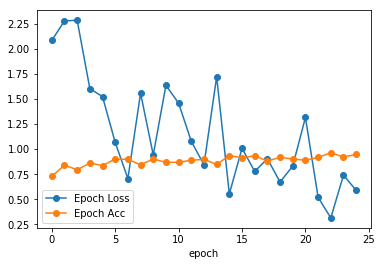

In [6]:
train_model(model_conv_ex, num_epochs = 25)

## 5.4. Run prediction

In [31]:
# Load Image Function from path
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

In [66]:
# Show pred image function
def imshow(inp, title=None):
    """Imshow for Tensor."""
    npimg = inp.squeeze().numpy().transpose(1,2,0)
    print (npimg.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg, interpolation='nearest')

(224, 224, 3)
tensor([[ 9.8335, -9.4959]])
Predicted class: ants


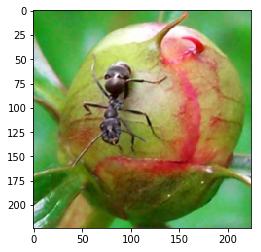

In [73]:
# Configs
imsize = 227
loader = transforms.Compose([transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Input images
pred_image_path = data_dir + "test/Test2.jpg" 
pred_image = image_loader(pred_image_path)
imshow(pred_image)

#Start prediction
output=model_conv_ex(pred_image)
print (output)
_, preds = torch.max(model_conv_ex(pred_image), 1)

print ('Predicted class:', class_names[preds])